In [82]:
import yfinance as yf

# Download BTC and ETH daily data (last 2 years)
btc = yf.download("BTC-USD", start="2018-01-01", end="2025-07-01", multi_level_index=False)
eth = yf.download("ETH-USD", start="2018-01-01", end="2025-07-01", multi_level_index=False)

print(eth.head(20))



C:\Users\nikhi\AppData\Local\Temp\ipykernel_15732\458435239.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download("BTC-USD", start="2018-01-01", end="2025-07-01", multi_level_index=False)
[*********************100%***********************]  1 of 1 completed
C:\Users\nikhi\AppData\Local\Temp\ipykernel_15732\458435239.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  eth = yf.download("ETH-USD", start="2018-01-01", end="2025-07-01", multi_level_index=False)
[*********************100%***********************]  1 of 1 completed

                  Close         High          Low         Open      Volume
Date                                                                      
2018-01-01   772.640991   782.530029   742.004028   755.757019  2595760128
2018-01-02   884.443970   914.830017   772.346008   772.346008  5783349760
2018-01-03   962.719971   974.471008   868.450989   886.000000  5093159936
2018-01-04   980.921997  1045.079956   946.085999   961.713013  6502859776
2018-01-05   997.719971  1075.390015   956.325012   975.750000  6683149824
2018-01-06  1041.680054  1060.709961   994.622009   995.153992  4662219776
2018-01-07  1153.170044  1153.170044  1043.010010  1043.010010  5569880064
2018-01-08  1148.530029  1266.930054  1016.049988  1158.260010  8450970112
2018-01-09  1299.739990  1320.979980  1145.489990  1146.000000  7965459968
2018-01-10  1255.819946  1417.380005  1226.599976  1300.339966  9214950400
2018-01-11  1154.930054  1337.300049  1135.170044  1268.089966  7235899904
2018-01-12  1273.199951  

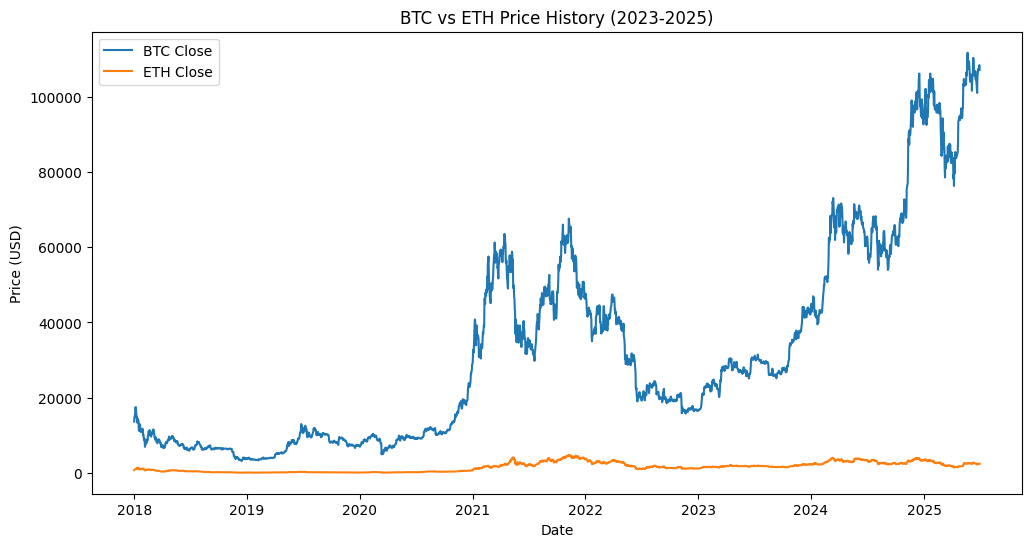

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(btc['Close'], label='BTC Close')
plt.plot(eth['Close'], label='ETH Close')
plt.title('BTC vs ETH Price History (2023-2025)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


This is just for my own personal inspection. Next I'm making a graph to show the relative price movements between BTC and ETH.

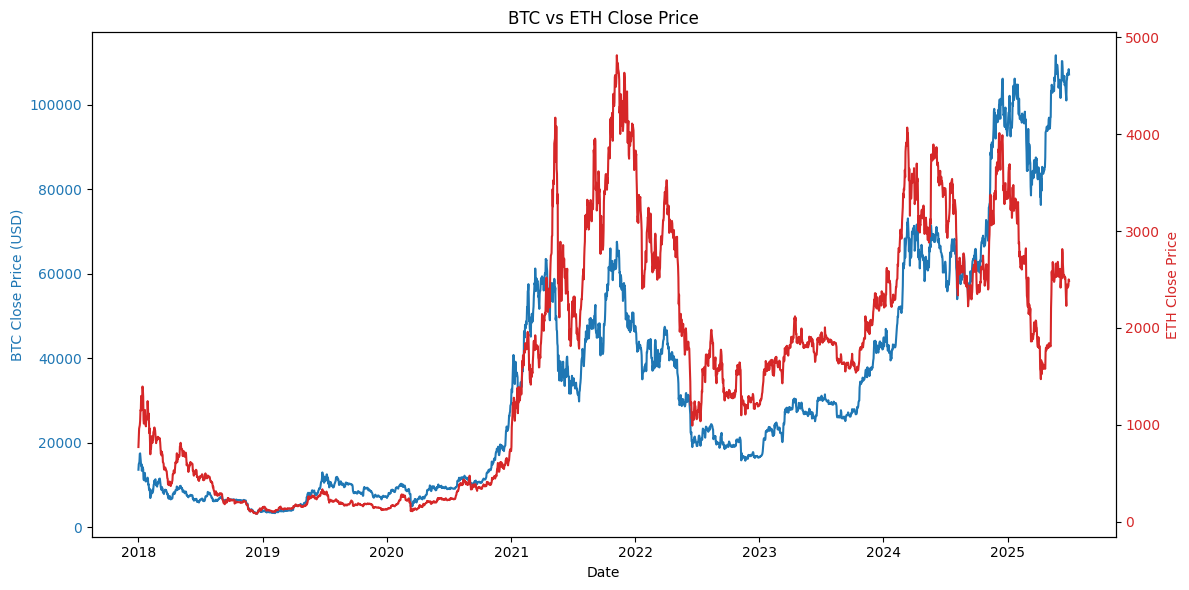

In [84]:

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# First Y-axis (left) for BTC Close Price
ax1.set_xlabel("Date")
ax1.set_ylabel("BTC Close Price (USD)", color='tab:blue')
ax1.plot(btc.index, btc['Close'], color='tab:blue', label='Close Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create second Y-axis (right) for SMAs
ax2 = ax1.twinx()  # share the same x-axis

ax2.set_ylabel("ETH Close Price", color='tab:red')
ax2.plot(btc.index, eth['Close'], color='tab:red', label='Close Price')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add title and show plot
plt.title("BTC vs ETH Close Price")
fig.tight_layout()
plt.show()


This graph above doesn't actually give much insight due to the scales of each graph. We can see relative shifts in price movement but not overall returns. To look for overall returns, I will look a the price action against the price of each asset on 2021-01-01. 

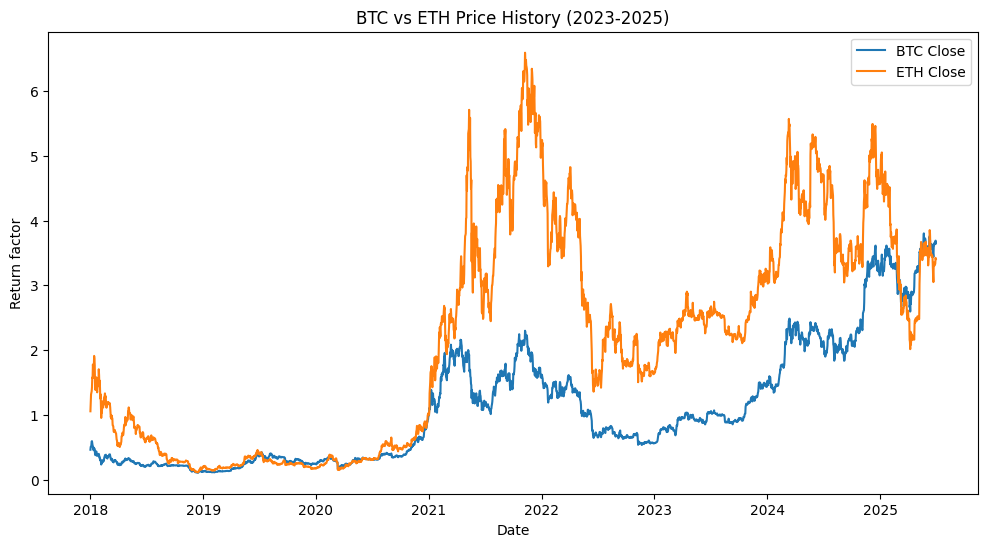

In [85]:
plt.figure(figsize=(12,6))
plt.plot(btc['Close']/btc.loc["2021-01-01", "Close"], label='BTC Close')
plt.plot(eth['Close']/eth.loc["2021-01-01", "Close"], label='ETH Close')
plt.title('BTC vs ETH Price History (2023-2025)')
plt.xlabel('Date')
plt.ylabel('Return factor')
plt.legend()
plt.show()

Now we are going to plot the 20-day SMA and the 50-day SMA by taking the rolling close price over the last 20 and 50 days respectively. The SMA is the standard moving average and when the 20 day SMA crosses the line of the 50 day SMA, it can be seen as a short term bullish trend and vice versa.

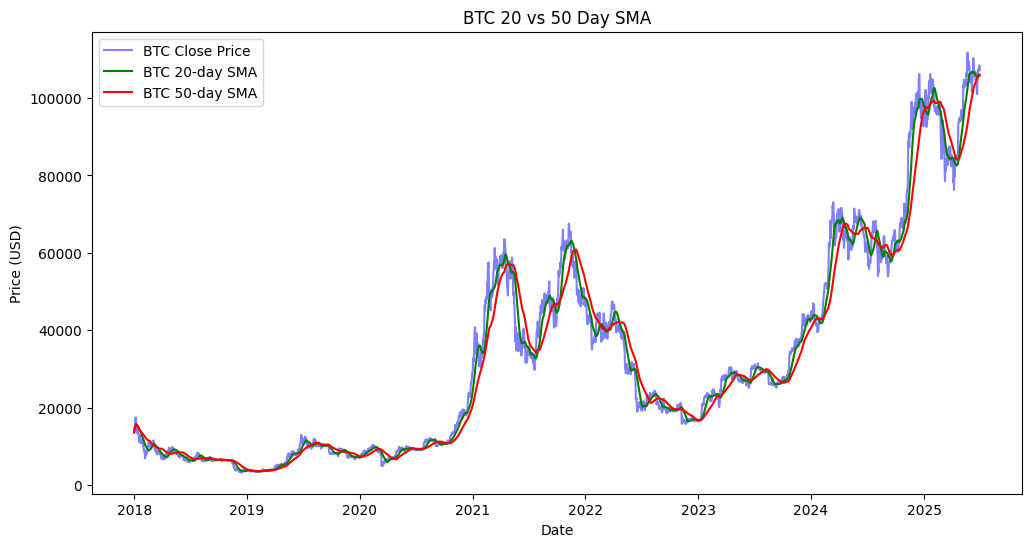

In [86]:


# Calculate SMAs (allowing partial windows)
# The partial windows just mean that 
btc['SMA_20'] = btc['Close'].rolling(window=20, min_periods=1).mean()
btc['SMA_50'] = btc['Close'].rolling(window=50, min_periods=1).mean()

# Plot
plt.figure(figsize=(12,6))
plt.plot(btc.index, btc['Close'], label='BTC Close Price', color='blue', alpha=0.5)
plt.plot(btc.index, btc['SMA_20'], label='BTC 20-day SMA', color='green')
plt.plot(btc.index, btc['SMA_50'], label='BTC 50-day SMA', color='red')
plt.title('BTC 20 vs 50 Day SMA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


Now that we have plotted the SMAs, we are going to backtest the trading strategy of longing BTC when the 20-day SMA crosses above the 50-day SMA and shorting BTC when the 20-day SMA crosses under the 50-day SMA.

To start, let's find all the points where the lines cross over eachother and categorise them into being either long or shorting points. To do this we will just find the difference in each SMA at each timestep, and when the difference changes in polarity, that will mark an intersection.

In [87]:
# defining long and short entries/exits (longs are 1, shorts are 2)
flip_identifier = []

# Working out the difference in SMAs
SMA_diff = btc['SMA_20'] - btc['SMA_50']

# Creating a boolean series for polarity flips
polarity_flip = SMA_diff.shift(1) * SMA_diff < 0

# The logic here is that when the SMA 20/50 days intersect, their difference changes in polarity
# When the difference changes from negative to positive we long (1)
# When the difference changes from positive to negative we short (2)
for i in range(len(SMA_diff)):

    if polarity_flip[i] == False:

        flip_identifier.append(0)

    if polarity_flip[i] == True:

        if SMA_diff[i] - SMA_diff[i-1] > 0:

            flip_identifier.append(1)

        if SMA_diff[i] - SMA_diff[i-1] < 0:

            flip_identifier.append(2)



print(flip_identifier)




[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

C:\Users\nikhi\AppData\Local\Temp\ipykernel_15732\4028436576.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if polarity_flip[i] == False:
C:\Users\nikhi\AppData\Local\Temp\ipykernel_15732\4028436576.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if polarity_flip[i] == True:
C:\Users\nikhi\AppData\Local\Temp\ipykernel_15732\4028436576.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if SMA_diff[i] - SMA_diff[i-1] > 0:

Now we need to calculate the entry and exits of our long and shorts

In [88]:
import numpy as np
import pandas as pd

trades = pd.DataFrame(columns=['EntryDate', 'EntryPrice', 'ExitDate', 'ExitPrice', 'Position', 'PnL'])

# Convert the Close Price column to a 1D numpy array
btc_prices_array = btc['Close'].to_numpy()
btc_dates_array = btc.index.to_numpy()

for i in range(len(flip_identifier)):

    row_index = len(trades)

    if flip_identifier[i] == 1:

        if row_index != 0:

            if trades.loc[row_index - 1, 'Position'] == "Short":
                        
                trades.loc[row_index - 1, 'ExitDate'] = btc_dates_array[i]
                trades.loc[row_index - 1, 'ExitPrice'] = btc_prices_array[i]

                trades.loc[row_index - 1, 'PnL'] = (trades.loc[row_index - 1, 'ExitPrice'] - trades.loc[row_index - 1, 'EntryPrice']) * -1

        trades.loc[row_index, 'EntryDate'] = btc_dates_array[i]
        trades.loc[row_index, 'EntryPrice'] = btc_prices_array[i]
        trades.loc[row_index, 'ExitDate'] = None
        trades.loc[row_index, 'ExitPrice'] = None
        trades.loc[row_index, 'Position'] = "Long"
        trades.loc[row_index, 'PnL'] = None
        
        

    if flip_identifier[i] == 2:

        if row_index != 0:

            if trades.loc[row_index - 1, 'Position'] == "Long":
                        
                trades.loc[row_index - 1, 'ExitDate'] = btc_dates_array[i]
                trades.loc[row_index - 1, 'ExitPrice'] = btc_prices_array[i]

                trades.loc[row_index - 1, 'PnL'] = trades.loc[row_index - 1, 'ExitPrice'] - trades.loc[row_index - 1, 'EntryPrice']

        trades.loc[row_index, 'EntryDate'] = btc_dates_array[i]
        trades.loc[row_index, 'EntryPrice'] = btc_prices_array[i]
        trades.loc[row_index, 'ExitDate'] = None
        trades.loc[row_index, 'ExitPrice'] = None
        trades.loc[row_index, 'Position'] = "Short"
        trades.loc[row_index, 'PnL'] = None




print(trades)



                        EntryDate     EntryPrice  \
0   2018-01-22T00:00:00.000000000   10931.400391   
1   2018-03-04T00:00:00.000000000   11512.599609   
2   2018-03-21T00:00:00.000000000    8929.280273   
3   2018-04-27T00:00:00.000000000    8987.049805   
4   2018-05-26T00:00:00.000000000    7355.879883   
5   2018-07-22T00:00:00.000000000    7418.490234   
6   2018-08-17T00:00:00.000000000    6580.629883   
7   2019-01-07T00:00:00.000000000    4025.248291   
8   2019-01-26T00:00:00.000000000    3602.460449   
9   2019-02-22T00:00:00.000000000    4005.526611   
10  2019-07-29T00:00:00.000000000    9519.145508   
11  2019-08-17T00:00:00.000000000   10231.744141   
12  2019-08-28T00:00:00.000000000    9754.422852   
13  2019-11-05T00:00:00.000000000    9342.527344   
14  2019-11-24T00:00:00.000000000    7047.916992   
15  2020-01-08T00:00:00.000000000    8079.862793   
16  2020-03-06T00:00:00.000000000    9122.545898   
17  2020-04-19T00:00:00.000000000    7189.424805   
18  2020-06-

Next, we need to find the cumulative PNL of all of the trades.

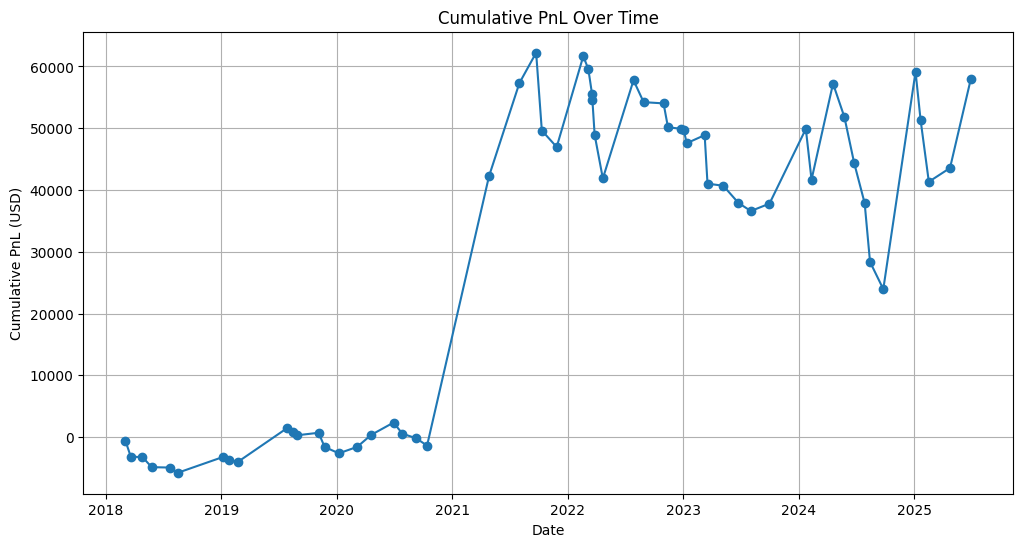

In [89]:
# Only consider rows where PnL is not NaN (trades that have closed)
closed_trades = trades.dropna(subset=['PnL']).copy()

# Convert ExitDate to datetime if it isn't already
closed_trades['ExitDate'] = pd.to_datetime(closed_trades['ExitDate'])

# Calculate cumulative PnL
closed_trades['CumulativePnL'] = closed_trades['PnL'].cumsum()

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(closed_trades['ExitDate'], closed_trades['CumulativePnL'], marker='o')
plt.title('Cumulative PnL Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL (USD)')
plt.grid(True)
plt.show()

